In [1]:
# Some tests of NuSTAR lightcurves in comparison to other X-ray data
# 
# 11-04-2023    IGH

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy import timeseries as ts
from sunpy.time import parse_time
from astropy.io import fits
import astropy.units as u
import datetime
import pandas as pd
import os
from pathlib import Path
import glob
from stixdcpy.quicklook import LightCurves
from stixdcpy.net import Request as jreq

import nsx_func

import warnings
warnings.simplefilter('ignore')

plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
            'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [2]:
# List of all the NuSTAR observations, with my naming, 
# based off first day of observing per campaign
dobs=['20140910','20141101','20141211',
    '20150429','20150901',
    '20160219','20160422','20160726',
    '20170321','20170821','20170911','20171010',
    '20180529','20180907','20180928',
    '20190112','20190412','20190425','20190702',
    '20200129','20200221','20200606','20200912',
    '20210108','20210429','20210720','20210730','20211117',
    '20220224','20220603','20220906','20221209',
    '20230318']

# Data directory
ddir=str(Path.home())+'/data/heasarc_nustar/'

In [3]:
# Find all pointings/IDs for the chosen observation 
# Do Feb 2002 for this initial test
icamp=32 #28 #26
maindir=ddir+'ns_'+dobs[icamp]+'/'
print(maindir)
# Most start with 20 or 90?
ids = [f.name for f in os.scandir(maindir) \
    if (f.is_dir() and (f.name.startswith('20') or f.name.startswith('90')))]
ids=sorted(ids)
for i in ids:
    print(i)


/Users/iain/data/heasarc_nustar/ns_20230318/
20801021001
20801022001
20801023001
20801024001
20801025001
20801026001
20801027001


In [18]:
nsid=ids[3]
print(nsid)

df_test=nsx_func.nsrate(maindir=maindir,nsid=nsid,lvt=False,englow=2,enghigh=10)
df10 = df_test.resample('10s', level=0).mean()

dft0=nsx_func.nsrate(maindir=maindir,nsid=nsid,lvt=False,englow=2,enghigh=10,det_id=[0])
df0= dft0.resample('10s', level=0).mean()
dft1=nsx_func.nsrate(maindir=maindir,nsid=nsid,lvt=False,englow=2,enghigh=10,det_id=[1])
df1= dft1.resample('10s', level=0).mean()
dft2=nsx_func.nsrate(maindir=maindir,nsid=nsid,lvt=False,englow=2,enghigh=10,det_id=[2])
df2= dft2.resample('10s', level=0).mean()
dft3=nsx_func.nsrate(maindir=maindir,nsid=nsid,lvt=False,englow=2,enghigh=10,det_id=[3])
df3= dft3.resample('10s', level=0).mean()




20801024001


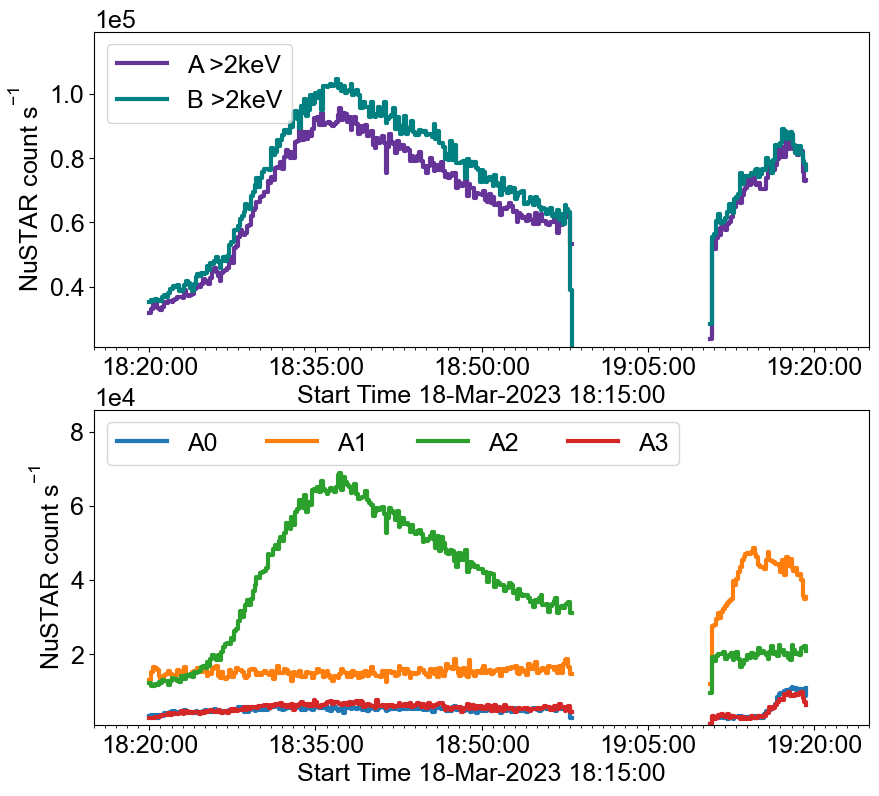

In [25]:
mint=df10.index[0].to_pydatetime()
mint-=datetime.timedelta(minutes=5,seconds=mint.second)
mint-=datetime.timedelta(minutes=mint.minute % 5)
maxt=df10.index[-1].to_pydatetime()
maxt+=datetime.timedelta(minutes=5,seconds=60-maxt.second)
maxt-=datetime.timedelta(minutes=maxt.minute % 5)
tr=[mint,maxt]
alldata=np.concatenate((df10["rta"].values,df10["rta"].values))
alldata=alldata[alldata > 0]
maxy=1.25*max(alldata)
miny=0.9*min(alldata)
yr=[miny,maxy]

alldet=np.concatenate((df0["rta"].values,df1["rta"].values,df2["rta"].values,df3["rta"].values))
yrdet=[0.9*min(alldet),1.25*max(alldet)]

myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.MinuteLocator(interval=15)
minorx= matplotlib.dates.MinuteLocator(interval=1)

fig, axs= plt.subplots(2,figsize=(10, 9))
plt.rcParams.update({'font.size': 18})
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
axs[0].plot(df10.index,df10["rta"].values,drawstyle='steps-post',\
    lw=3,color='rebeccapurple',label='A >2keV')
axs[0].plot(df10.index,df10["rtb"].values,drawstyle='steps-post',\
    lw=3,color='teal',label='B >2keV')
axs[0].set_ylim(yr)
axs[0].legend(loc=2)
axs[1].plot(df0.index,df0["rta"].values,drawstyle='steps-post',lw=3,label='A0')
axs[1].plot(df1.index,df1["rta"].values,drawstyle='steps-post',lw=3,label='A1')
axs[1].plot(df2.index,df2["rta"].values,drawstyle='steps-post',lw=3,label='A2')
axs[1].plot(df3.index,df3["rta"].values,drawstyle='steps-post',lw=3,label='A3')
axs[1].set_ylim(yrdet)
axs[1].legend(loc=2,ncol=4)
for ax in axs:
    ax.set_xlabel(f'Start Time {mint:%d-%b-%Y %H:%M:%S}')
    ax.set_xlim(tr)
    ax.set_ylabel('NuSTAR count s$^{-1}$')
    ax.xaxis.set_major_locator(majorx)
    ax.xaxis.set_minor_locator(minorx)
    ax.xaxis.set_major_formatter(myFmt)
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
plt.show()

In [5]:
# NuSTAR only lightcurves

# for nsid in ids:
#     print(nsid)
#     df_test=nsx_func.nsrate(maindir=maindir,nsid=nsid,lvt=False,englow=2,enghigh=10)
#     df10 = df_test.resample('10s', level=0).mean()

#     # Time range to nearest 5mins
#     mint=df10.index[0].to_pydatetime()
#     mint-=datetime.timedelta(minutes=5,seconds=mint.second)
#     mint-=datetime.timedelta(minutes=mint.minute % 5)
#     maxt=df10.index[-1].to_pydatetime()
#     maxt+=datetime.timedelta(minutes=5,seconds=60-maxt.second)
#     maxt-=datetime.timedelta(minutes=maxt.minute % 5)
#     tr=[mint,maxt]
    
#     # yrange for NuSTAR plot
#     alldata=np.concatenate((df10["rta"].values,df10["rta"].values))
#     alldata=alldata[alldata > 0]
#     maxy=1.25*max(alldata)
#     miny=0.9*min(alldata)
#     yr=[miny,maxy]

#     # Control the time axis labelling
#     myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
#     majorx= matplotlib.dates.MinuteLocator(interval=15)
#     minorx= matplotlib.dates.MinuteLocator(interval=1)

#     fig, ax= plt.subplots(1,figsize=(10, 5))
#     plt.rcParams.update({'font.size': 18})
#     plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
#     ax.plot(df10.index,df10["rta"].values,drawstyle='steps-post',\
#         lw=3,color='rebeccapurple',label='A >2keV')
#     ax.plot(df10.index,df10["rtb"].values,drawstyle='steps-post',\
#         lw=3,color='teal',label='B >2keV')
#     ax.set_xlabel(f'Start Time {mint:%d-%b-%Y %H:%M:%S}')
#     ax.set_xlim(tr)
#     ax.set_ylim(yr)
#     ax.set_ylabel('NuSTAR count s$^{-1}$')
#     ax.xaxis.set_major_locator(majorx)
#     ax.xaxis.set_minor_locator(minorx)
#     ax.xaxis.set_major_formatter(myFmt)
#     ax.legend(loc=2)
#     ax.set_title(nsid)
#     fig.subplots_adjust(bottom=0.15, top=0.9, left=0.12, right=0.95)
#     plt.savefig('figs/ns_'+dobs[icamp]+f'/ltc_{mint:%Y%m%d_%H%M}_'+nsid+'_n.png')
#     # as looping don't need to plot the figures to the notebook
#     plt.close()

In [6]:
#  sunpy still only returns the 1s GOES16-18 data and not the avg1min one
# So will need to manually download myself, and then search in that local directory for them
#  Just work with GOES16 as covers 2020 to now
# i.e. https://ngdc.noaa.gov/stp/satellite/goes/doc/GOES_XRS_readme.pdf
# 
# Need to manually get the data from 
# https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/xrsf-l2-avg1m_science/
gdir=str(Path.home())+'/data/goes_xrs/'

In [7]:
# GOES/XRS + NuSTAR lightcurves

# for nsid in ids:
#     print(nsid)

#     df_test=nsx_func.nsrate(maindir=maindir,nsid=nsid,lvt=False,englow=2,enghigh=10)
#     df10 = df_test.resample('10s', level=0).mean()

#     # Time range to nearest 5mins
#     mint=df10.index[0].to_pydatetime()
#     mint-=datetime.timedelta(minutes=5,seconds=mint.second)
#     mint-=datetime.timedelta(minutes=mint.minute % 5)
#     maxt=df10.index[-1].to_pydatetime()
#     maxt+=datetime.timedelta(minutes=5,seconds=60-maxt.second)
#     maxt-=datetime.timedelta(minutes=maxt.minute % 5)
#     tr=[mint,maxt]

#     # Get the GOES XRS data
#     gtimf=np.unique([f'{mint:%Y%m%d}',f'{maxt:%Y%m%d}'])
#     gfiles=[glob.glob(gdir+'*'+g+'*')[0] for g in gtimf]
#     trange=a.Time(tr[0],tr[1])
#     gxrs = ts.TimeSeries(gfiles, concatenate=True)
#     gxrst=gxrs.truncate(trange.start.iso,trange.end.iso)
#     tg_tims=gxrst.index
#     tg_x05=gxrst.quantity("xrsa").value
#     tg_x18=gxrst.quantity("xrsb").value

#     # Anything in the GOES flare list? Obviously needs the internet to work
#     gsflin = Fido.search(trange,a.hek.EventType("FL"),a.hek.FRM.Name == "SSW Latest Events")
#     gsflhk=gsflin["hek"]

#     # yrange for NuSTAR plot
#     alldata=np.concatenate((df10["rta"].values,df10["rta"].values))
#     alldata=alldata[alldata > 0]
#     maxy=1.25*max(alldata)
#     miny=0.9*min(alldata)
#     yr=[miny,maxy]
#     # print(yr,np.median(alldata))

#     # Control the time axis labelling
#     myFmt = matplotlib.dates.DateFormatter('%H:%M')
#     majorx= matplotlib.dates.MinuteLocator(interval=10)
#     minorx= matplotlib.dates.MinuteLocator(interval=1)

#     fig, axs= plt.subplots(2,figsize=(10, 9))
#     plt.rcParams.update({'font.size': 18})
#     # axs[0].plot(tg_tims,tg_x05,drawstyle='steps-post',\
#     #     marker=None,color='darkblue',lw=2,label='$0.5-4\;\AA$')
#     axs[0].plot(tg_tims,tg_x18,drawstyle='steps-post',\
#         marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')
#     axs[0].set_ylabel('GOES16/XRS [W$\;m^{-2}$]')
#     axs[0].set_ylim([0.9*np.min(tg_x18),1.2*np.max(tg_x18)])

#     for gg in gsflhk:
#         tfl=a.Time(gg["event_starttime"],gg["event_endtime"])
#         ptim=parse_time(gg["event_peaktime"]).datetime
#         axs[0].axvspan(tfl.start.datetime,tfl.end.datetime,color='silver',alpha=0.4, \
#             label=gg["fl_goescls"]+f' ({ptim:%H:%M})')
#         axs[0].axvline(ptim,color='black',ls='-.')
#         axs[1].axvline(ptim,color='black',ls='-.')
#     axs[0].legend(loc=2,ncols=3)
#     plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
#     axs[1].plot(df10.index,df10["rta"].values,drawstyle='steps-post',\
#         lw=2,color='rebeccapurple',label='A >2keV')
#     axs[1].plot(df10.index,df10["rtb"].values,drawstyle='steps-post',\
#         lw=2,color='teal',label='B >2keV')
#     axs[1].set_xlabel(f'Start Time {mint:%d-%b-%Y %H:%M:%S}')
#     axs[1].set_ylabel('NuSTAR [count$\;s^{-1}$]')
#     axs[1].set_ylim(yr)
#     axs[1].legend(loc=2)
#     for ax in axs:
#         ax.set_xlim(tr)
#         ax.xaxis.set_major_locator(majorx)
#         ax.xaxis.set_minor_locator(minorx)
#         ax.xaxis.set_major_formatter(myFmt)
#     # axs[1].set_title(nsid)
#     plt.annotate(nsid,(0.03,0.03),xycoords='figure fraction',fontsize=14)

#     fig.subplots_adjust(bottom=0.1, top=0.95, left=0.12, right=0.95)
#     plt.savefig('figs/ns_'+dobs[icamp]+f'/ltc_{mint:%Y%m%d_%H%M}_'+nsid+'_ng.png')
#     # as looping don't need to plot the figures to the notebook
#     plt.close()

In [8]:
# # STIX + GOES/XRS + NuSTAR  lightcurves

# for nsid in ids:
#     print(nsid)

#     df_test=nsx_func.nsrate(maindir=maindir,nsid=nsid,lvt=False,englow=2,enghigh=10)
#     df10 = df_test.resample('10s', level=0).mean()

#     # Time range to nearest 5mins
#     mint=df10.index[0].to_pydatetime()
#     mint-=datetime.timedelta(minutes=5,seconds=mint.second)
#     mint-=datetime.timedelta(minutes=mint.minute % 5)
#     maxt=df10.index[-1].to_pydatetime()
#     maxt+=datetime.timedelta(minutes=5,seconds=60-maxt.second)
#     maxt-=datetime.timedelta(minutes=maxt.minute % 5)
#     tr=[mint,maxt]

#     # Get the GOES XRS data
#     gtimf=np.unique([f'{mint:%Y%m%d}',f'{maxt:%Y%m%d}'])
#     gfiles=[glob.glob(gdir+'*'+g+'*')[0] for g in gtimf]
#     trange=a.Time(tr[0],tr[1])
#     gxrs = ts.TimeSeries(gfiles, concatenate=True)
#     gxrst=gxrs.truncate(trange.start.iso,trange.end.iso)
#     tg_tims=gxrst.index
#     tg_x05=gxrst.quantity("xrsa").value
#     tg_x18=gxrst.quantity("xrsb").value

#     # Get the STIX quicklook data
#     slc = LightCurves.from_sdc(start_utc=tr[0], end_utc=tr[1], ltc=True)
#     stx_eb=slc.data["energy_bins"]
#     # Connvert to dataframe, then can easily truncate to actual timerange
#     slc_df = pd.DataFrame(np.array(slc.data["counts"]).T,index=slc.time, columns=slc.data["energy_bins"]["names"])
#     slc_df_tr = slc_df.truncate(tr[0],tr[1])

#     # Anything in the GOES flare list? Obviously needs the internet to work
#     gsflin = Fido.search(trange,a.hek.EventType("FL"),a.hek.FRM.Name == "SSW Latest Events")
#     gsflhk=gsflin["hek"]

#     # yrange for NuSTAR plot
#     alldata=np.concatenate((df10["rta"].values,df10["rta"].values))
#     alldata=alldata[alldata > 0]
#     maxy=1.25*max(alldata)
#     miny=0.9*min(alldata)
#     yr=[miny,maxy]
#     # print(yr,np.median(alldata))

#     # Control the time axis labelling
#     myFmt = matplotlib.dates.DateFormatter('%H:%M')
#     majorx= matplotlib.dates.MinuteLocator(interval=10)
#     minorx= matplotlib.dates.MinuteLocator(interval=1)
#     plt.rcParams.update({'font.size': 18})
#     fig, axs= plt.subplots(3,figsize=(10, 12))
#     slcdata=slc_df_tr[stx_eb["names"][0]].values
#     axs[0].plot(slc_df_tr.index, slcdata,drawstyle='steps-post',\
#         marker=None,color='steelblue',lw=2,label=stx_eb["names"][0])
#     axs[0].set_ylabel('STIX [counts]')
#     axs[0].set_ylim([0.9*np.min(slcdata),1.2*np.max(slcdata)])
#     axs[0].legend(loc=2)

#     axs[1].plot(tg_tims,tg_x18,drawstyle='steps-post',\
#         marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')
#     axs[1].set_ylabel('GOES16/XRS [W$\;m^{-2}$]')
#     axs[1].set_ylim([0.9*np.min(tg_x18),1.2*np.max(tg_x18)])

#     for gg in gsflhk:
#         tfl=a.Time(gg["event_starttime"],gg["event_endtime"])
#         ptim=parse_time(gg["event_peaktime"]).datetime
#         axs[1].axvspan(tfl.start.datetime,tfl.end.datetime,color='silver',alpha=0.4, \
#             label=gg["fl_goescls"]+f' ({ptim:%H:%M})')
#         for ax in axs:
#             ax.axvline(ptim,color='black',ls='-.')
#     axs[1].legend(loc=2,ncols=3)
#     axs[2].plot(df10.index,df10["rta"].values,drawstyle='steps-post',\
#         lw=2,color='rebeccapurple',label='A >2keV')
#     axs[2].plot(df10.index,df10["rtb"].values,drawstyle='steps-post',\
#         lw=2,color='teal',label='B >2keV')
#     axs[2].set_xlabel(f'Start Time {mint:%d-%b-%Y %H:%M:%S}')
#     axs[2].set_ylabel('NuSTAR [count$\;s^{-1}$]')
#     axs[2].set_ylim(yr)
#     axs[2].legend(loc=2)
#     for ax in axs:
#         ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
#         ax.set_xlim(tr)
#         ax.xaxis.set_major_locator(majorx)
#         ax.xaxis.set_minor_locator(minorx)
#         ax.xaxis.set_major_formatter(myFmt)
#     plt.annotate(nsid,(0.03,0.03),xycoords='figure fraction',fontsize=14)

#     fig.subplots_adjust(bottom=0.1, top=0.95, left=0.12, right=0.95)
#     plt.savefig('figs/ns_'+dobs[icamp]+f'/ltc_{mint:%Y%m%d_%H%M}_'+nsid+'_ngs.png')
#     # as looping don't need to plot the figures to the notebook
#     plt.close()

In [9]:
# Do all of 2022 and 2023 (so far) but not June (as mosaics and don't have locally)
for icamp in [28,30,31,32]:
    maindir=ddir+'ns_'+dobs[icamp]+'/'
    print(maindir)
    # Most start with 20 or 90?
    ids = [f.name for f in os.scandir(maindir) \
        if (f.is_dir() and (f.name.startswith('20') or f.name.startswith('90')))]
    ids=sorted(ids)
    print(ids)

    # If doing June 2022 would need to filter out the mosaic pointings
    # # STIX + GOES/XRS + NuSTAR  lightcurves
    for nsid in ids:
        print(nsid)

        df_test=nsx_func.nsrate(maindir=maindir,nsid=nsid,lvt=False,englow=2,enghigh=10)
        df10 = df_test.resample('10s', level=0).mean()

        # Time range to nearest 5mins
        mint=df10.index[0].to_pydatetime()
        mint-=datetime.timedelta(minutes=5,seconds=mint.second)
        mint-=datetime.timedelta(minutes=mint.minute % 5)
        maxt=df10.index[-1].to_pydatetime()
        maxt+=datetime.timedelta(minutes=5,seconds=60-maxt.second)
        maxt-=datetime.timedelta(minutes=maxt.minute % 5)
        tr=[mint,maxt]

        # Get the GOES XRS data
        gtimf=np.unique([f'{mint:%Y%m%d}',f'{maxt:%Y%m%d}'])
        gfiles=[glob.glob(gdir+'*'+g+'*')[0] for g in gtimf]
        trange=a.Time(tr[0],tr[1])
        gxrs = ts.TimeSeries(gfiles, concatenate=True)
        gxrst=gxrs.truncate(trange.start.iso,trange.end.iso)
        tg_tims=gxrst.index
        tg_x05=gxrst.quantity("xrsa").value
        tg_x18=gxrst.quantity("xrsb").value

        # Get the STIX quicklook data
        slc = LightCurves.from_sdc(start_utc=tr[0], end_utc=tr[1], ltc=True)
        stx_eb=slc.data["energy_bins"]
        # Connvert to dataframe, then can easily truncate to actual timerange
        slc_df = pd.DataFrame(np.array(slc.data["counts"]).T,index=slc.time, columns=slc.data["energy_bins"]["names"])
        slc_df_tr = slc_df.truncate(tr[0],tr[1])

        # Anything in the GOES flare list? Obviously needs the internet to work
        gsflin = Fido.search(trange,a.hek.EventType("FL"),a.hek.FRM.Name == "SSW Latest Events")
        gsflhk=gsflin["hek"]

        # Stuff in STIX flare list?
        # Don't fully trust what this is giving me (and no positions of course)
        # stxfl=jreq.fetch_flare_list(trange.start.isot, trange.end.isot, sort='time')

        # yrange for NuSTAR plot
        alldata=np.concatenate((df10["rta"].values,df10["rta"].values))
        alldata=alldata[alldata > 0]
        maxy=1.25*max(alldata)
        miny=0.9*min(alldata)
        yr=[miny,maxy]
        # print(yr,np.median(alldata))

        # Control the time axis labelling
        myFmt = matplotlib.dates.DateFormatter('%H:%M')
        majorx= matplotlib.dates.MinuteLocator(interval=10)
        minorx= matplotlib.dates.MinuteLocator(interval=1)
        plt.rcParams.update({'font.size': 18})
        fig, axs= plt.subplots(3,figsize=(10, 12))
        slcdata=slc_df_tr[stx_eb["names"][0]].values
        axs[0].plot(slc_df_tr.index, slcdata,drawstyle='steps-post',\
            marker=None,color='steelblue',lw=2,label=stx_eb["names"][0])
        axs[0].set_ylabel('STIX [counts]')
        axs[0].set_ylim([0.9*np.min(slcdata),1.2*np.max(slcdata)])
        axs[0].legend(loc=2)

        # for sf in stxfl:
        #     ptim_shft=parse_time(sf.get('peak_UTC'))+slc.data["SOLO_EARTH_LIGHT_TIME"]*u.s
        #     axs[0].axvline(ptim_shft.iso,color='steelblue',ls='--')

        axs[1].plot(tg_tims,tg_x18,drawstyle='steps-post',\
            marker=None,color='firebrick',lw=2,label='$1-8\;\AA$')
        axs[1].set_ylabel('GOES16/XRS [W$\;m^{-2}$]')
        axs[1].set_ylim([0.9*np.min(tg_x18),1.2*np.max(tg_x18)])

        for gg in gsflhk:
            tfl=a.Time(gg["event_starttime"],gg["event_endtime"])
            ptim=parse_time(gg["event_peaktime"]).datetime
            axs[1].axvspan(tfl.start.datetime,tfl.end.datetime,color='silver',alpha=0.4, \
                label=gg["fl_goescls"]+f' ({ptim:%H:%M})')
            # for ax in axs:
            #     ax.axvline(ptim,color='black',ls='-.')
            axs[1].axvline(ptim,color='black',ls='-.')
            axs[2].axvline(ptim,color='black',ls='-.')
        axs[1].legend(loc=2,ncols=3)
        axs[2].plot(df10.index,df10["rta"].values,drawstyle='steps-post',\
            lw=2,color='rebeccapurple',label='A >2keV')
        axs[2].plot(df10.index,df10["rtb"].values,drawstyle='steps-post',\
            lw=2,color='teal',label='B >2keV')
        axs[2].set_xlabel(f'Start Time {mint:%d-%b-%Y %H:%M:%S}')
        axs[2].set_ylabel('NuSTAR [count$\;s^{-1}$]')
        axs[2].set_ylim(yr)
        axs[2].legend(loc=2)
        for ax in axs:
            ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
            ax.set_xlim(tr)
            ax.xaxis.set_major_locator(majorx)
            ax.xaxis.set_minor_locator(minorx)
            ax.xaxis.set_major_formatter(myFmt)
        plt.annotate(nsid,(0.03,0.03),xycoords='figure fraction',fontsize=14)

        fig.subplots_adjust(bottom=0.1, top=0.95, left=0.12, right=0.95)
        plt.savefig('figs/ns_'+dobs[icamp]+f'/ltc_{mint:%Y%m%d_%H%M}_'+nsid+'_ngs.png')
        # as looping don't need to plot the figures to the notebook
        plt.close()


/Users/iain/data/heasarc_nustar/ns_20220224/
['20621001001', '20621002001', '20621003001', '20621004001', '20622001001', '20622002001', '20622003001', '20622004001', '20623001001', '20623002001', '20623003001', '20623004001']
20621001001
20621002001
20621003001
20621004001
20622001001
20622002001
20622003001
20622004001
20623001001
20623002001
20623003001
20623004001
/Users/iain/data/heasarc_nustar/ns_20220906/
['90810201001', '90810202001', '90810203001', '90810204001']
90810201001
90810202001
90810203001
90810204001
/Users/iain/data/heasarc_nustar/ns_20221209/
['20801011001', '20801012001', '20801013001', '20801014001', '20801015001', '20801016001', '20801017001']
20801011001
20801012001
20801013001
20801014001
20801015001
20801016001
20801017001
/Users/iain/data/heasarc_nustar/ns_20230318/
['20801021001', '20801022001', '20801023001', '20801024001', '20801025001', '20801026001', '20801027001']
20801021001
20801022001
20801023001
20801024001
20801025001
20801026001
20801027001
